In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import copy
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.random_projection import SparseRandomProjection
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

from time import perf_counter

from utilities import drawSketch, computeLearningCurve, plotScoreCurve, plotTimeCurve, plotIterationCurve, plotConfusionMatrix, getDrawData, drawIncorrectSketches, heatmap, get_pca_components_for_var, plot_pca_components, df_to_heatmap, get_reconstruction_error, get_max_along_df_axis


# Define settings

In [4]:
# Import shared settings
from settings import random_state, n_jobs, test_size, pRows, pCols, pColNames, pScale, nSamples, names, accuracyMin, accuracyMax, max_iter
# Override settings
#...

In [5]:
# Set n_components to be used during grid searching (was set here based on PCA)
n_components = [1, 2, 9, 34, 98, 156, 206, 295, 478, 666, 784]

In [6]:
# Used for plot names
dim_red_name = "rp"
casename = f"quickdraw_{dim_red_name}"
# scoreText = "Score (Classification Accuracy)"

# Load and curate data

In [7]:
dataDict = getDrawData(names, nSamples=nSamples)
data = dataDict['df']
nameDict = dataDict['nameDict']

print("")
print("Loaded the following named categories, with classNumbers shown")
print(nameDict)

# Scale pixel data
for col in pColNames:
    data[col] = data[col] / pScale

Loading 2500 samples for baseball from ./data/full_numpy_bitmap_baseball.npy
Loading 2500 samples for basketball from ./data/full_numpy_bitmap_basketball.npy

Loaded the following named categories, with classNumbers shown
{'baseball': 0, 'basketball': 1}


In [8]:
# Create X, y, X_test, y_test using just the features we care about...

X_full = data.loc[:, pColNames].values
print(f'X_full.shape = {X_full.shape}')
y_full = data.loc[:, 'classNumber'].values
print(f'y_full.shape = {y_full.shape}')

X, X_test, y, y_test = train_test_split(X_full, y_full, test_size=test_size, 
                                      random_state=random_state, stratify=y_full)

print('')
print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')
print(f'Ratio of y=1 to y=0 for Training data: {(y == 1).sum() / float(len(y))} (should be 0.5)')


print('')
print(f'X_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')
print(f'Ratio of y_test=1 to y_test=0 for Test data: {(y_test == 1).sum() / float(len(y_test))} (should be 0.5)')

X_full.shape = (5000, 784)
y_full.shape = (5000,)

X.shape = (4000, 784)
y.shape = (4000,)
Ratio of y=1 to y=0 for Training data: 0.5 (should be 0.5)

X_test.shape = (1000, 784)
y_test.shape = (1000,)
Ratio of y_test=1 to y_test=0 for Test data: 0.5 (should be 0.5)


# Apply RP

## Run MLP using results of RP through Grid Search

In [10]:
seeds = [0, 1, 2]
sweep_results = {}

In [8]:
for seed in seeds:
    print(f"running with seed = {seed}")
    sweep_results[seed] = {}
    pipe = Pipeline([('scaler', StandardScaler()),
                      (dim_red_name, SparseRandomProjection(random_state=seed)),
                      ('mlp', MLPClassifier(max_iter=max_iter, random_state=random_state))])

    hidden_layer_sizes = [(2, ), (4, ), (6, ), (10, )]
    param_grid = {f'{dim_red_name}__n_components': n_components,
                 'mlp__hidden_layer_sizes': hidden_layer_sizes,
                 }
    gs = GridSearchCV(pipe, param_grid=param_grid, verbose=10, cv=5, return_train_score=True, 
                      n_jobs=n_jobs)
    
    gs.fit(X, y)
    joblib.dump(gs, f"{casename}_gs_{seed}.pkl")
    sweep_results[seed]['gs'] = gs
    
    results = pd.DataFrame(gs.cv_results_)
    results.to_csv(f"{casename}_results_{seed}.csv")
    sweep_results[seed]['results'] = results

running with seed = 0
Fitting 5 folds for each of 44 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6

running with seed = 1
Fitting 5 folds for each of 44 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8

running with seed = 2
Fitting 5 folds for each of 44 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6

In [13]:
# for seed in seeds:
#     sweep_results[seed] = {
#         'results': pd.read_csv(f"{casename}_results_{seed}.csv")
#     }

Seed = 0


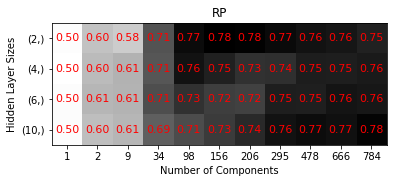

Seed = 1


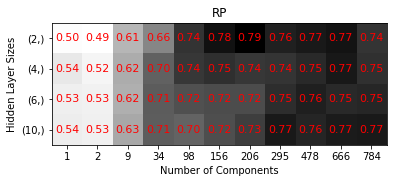

Seed = 2


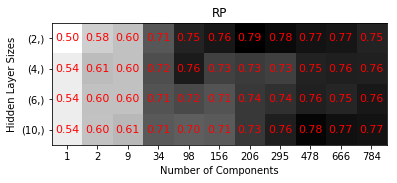

In [17]:
x_variable = f"param_{dim_red_name}__n_components"
y_variable = f"param_mlp__hidden_layer_sizes"
z_variable = "mean_test_score"

for seed in seeds:
    print(f"Seed = {seed}")
    df_to_heatmap(sweep_results[seed]['results'], x_variable, y_variable, z_variable, fontsize=11, title=f'{dim_red_name.upper()}', xlabel='Number of Components', ylabel='Hidden Layer Sizes', savefig=f'{casename}_gs_{seed}.png')
    plt.show()

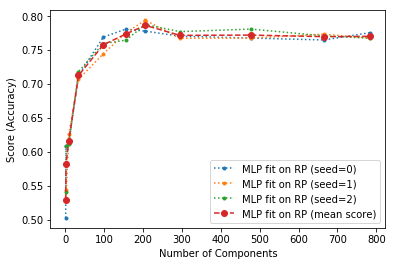

In [20]:
x_variable = f"param_{dim_red_name}__n_components"
z_variable = "mean_test_score"
fig, ax = plt.subplots()
len_x = len(sweep_results[0]['results'].loc[:, x_variable].unique())
mean_scores = np.zeros(len_x)
for seed in seeds:
    best_scores = get_max_along_df_axis(sweep_results[seed]['results'], z_variable, x_variable)
    mean_scores += best_scores[:, 1]
    ax.plot(best_scores[:, 0], best_scores[:, 1], '.:', label=f'MLP fit on {dim_red_name.upper()} (seed={seed})')
mean_scores /= len(seeds)
ax.plot(best_scores[:, 0], mean_scores, 'o--', label=f'MLP fit on {dim_red_name.upper()} (mean score)')

ax.set_xlabel("Number of Components")
ax.set_ylabel("Score (Accuracy)")
ax.legend()

fig.savefig(f'{casename}_random_summary.png')
plt.show()